In [1]:
import numpy as np

import scipy.sparse as sp # sparse matrix
import scipy.io as sio
import scipy as sci
import scipy.optimize as op#import minimize
from scipy.integrate import odeint
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import  scipy.integrate as integ

import csv as csv 
import math as math
from sklearn.metrics import mean_squared_error

import pandas as pd   
import seaborn as sn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import os
from pymcmcstat.MCMC import MCMC
from pymcmcstat.plotting import MCMCPlotting
import pymcmcstat
print(pymcmcstat.__version__)
np.seterr(over='ignore');

import dateutil as dt

# pour introduire les parametres
from lmfit import  Parameters, Parameter

import covid as cv

1.9.0
1.9.0


In [2]:
def import_data(index = 212, start = 4):
    #importing global data
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    confirmed_global = pd.read_csv(url, error_bad_lines=False)
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    deaths_global = pd.read_csv(url, error_bad_lines=False)
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    recovered_global = pd.read_csv(url, error_bad_lines=False)
    #extract data for Tunisia (or any other country when changing the index)
    #index = 212 # Tunisia's index in the dataset
    #start = 4 #remove the region columns to start from the first date in the dataset
    confirmed = confirmed_global.iloc[index,start:]
    deaths = deaths_global.iloc[index,start:]
    recovered = recovered_global.iloc[index,start:]
    d = {'confirmed': confirmed, 'deaths': deaths,'recovered': recovered}
    d = pd.DataFrame(d)
    d =d[d.confirmed != 0] # removing dates where there are no confirmed cases: dataset starts with the first confirmed case
    d = d.rename_axis('date').reset_index()
    return d

In [3]:
tn = import_data(212,4)
tn.head()

,date,confirmed,deaths,recovered
0,3/4/20,1,0,0
1,3/5/20,1,0,0
2,3/6/20,1,0,0
3,3/7/20,1,0,0
4,3/8/20,2,0,0


covid.py has predefined functions that we are going to use next for plots and modeling


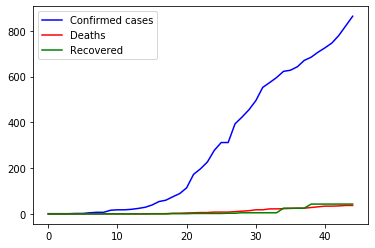

In [4]:
ddata = cv.data(data=tn,t_change=24)#24
ddata.plotData()

The cumulative number of reported symptomatic infectious cases at time t, denoted by $CR(t)$, is assumed to be:

$$ CR(t) = \chi_1 \exp(\chi_2 t) - \chi_3 $$

we fit the parameters and calulate goodness of fit measures

In [5]:
ddata.estimates_goodness()

The CR exponential growth parameters
x1=1.519
x2=0.220
x3=0.757
t0=-3.172
Goodness of fit measures
R2 =  0.9915408024133986
explained variance score 0.9916117601778949
MSE =  34.84102011443714


In [6]:
ddata.regression_report()

   Coefficients  Standard Errors  t values  P-values
0        0.2857            0.083     3.441  0.002225
1        0.2276            0.006    36.796  0.000000


We apply a t-test for the parameters $\chi_1, \chi_2$ and we obtain very small p_values. Hence, we reject H0 that $\chi_1 = 0$ and $\chi_2 =0$.

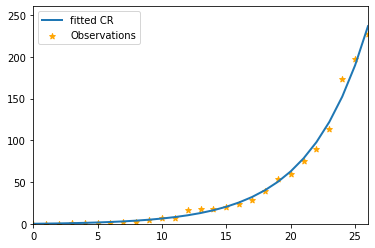

In [7]:
ddata.plot_CR()

Figure: fitted CR vs. real cumulative confimed cases in Tunisia

/home/slimane/biologie/corona/modelSAsymIR/simulation/covid.py:222: RuntimeWarning: divide by zero encountered in log
  log_obs[i] = np.log(obs1[i])


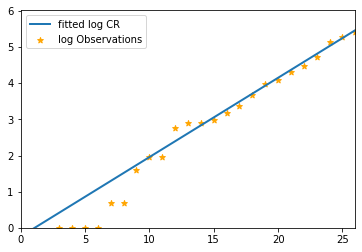

In [8]:
ddata.plot_logCR()    

Figure: fitted $\log(CR(t)+\chi_3)$ vs. real log. of cumulative confimed cases in Tunisia

In [9]:
ddata.preds_CR()

,date,predictions,observations
24,3/28/20,295.104773,278
25,3/29/20,367.786863,312
26,3/30/20,458.324231,312
27,3/31/20,571.103252,394
28,4/1/20,711.587870,423
29,4/2/20,886.584316,455
30,4/3/20,1104.570858,495
31,4/4/20,1376.108559,553
32,4/5/20,1714.352939,574
33,4/6/20,2135.691342,596


Donnée du covid 19

In [10]:
q=1/10# 0.1792 # 5-15 days
deathRate=1/25 # 25 day
ratioMu_gama=np.nanmean(ddata.deaths[18:]/ddata.recovered[18:])

p= ratioMu_gama*q/(deathRate+ratioMu_gama*q)
gama=(1-p)*q
mu1=p*deathRate #ratioMu_gama*gama
gama1=gama+mu1

p=0.2
mu=p*mu1
gama=(1-p)*mu1+gama

#mu=0.006800677358302621
#gama=0.042194242454427724
alpha1=3.529955342465704e-08

beta=Parameter('beta', value=1/6, min=0,max=1)
tau1=Parameter('tau1', value=0.35, min=0,max=1)
tau2=Parameter('tau2', value=0.778, min=0,max=1)
mu=Parameter('mu', value=mu,  min=0,max=1)
gama=Parameter('gama', value=gama,  min=0,max=1)
alpha1=Parameter('alpha1', value=alpha1,  min=0,max=1)
f=Parameter('f', value=3, min=0)
#Parametres liées au confinement
start_conf=Parameter('start_conf', value=3)
efficacite_Conf=Parameter('efficacite_Conf', value= 0.04, min=0,max=1)
confinement_hour=Parameter('confinement_hour',value=12, min=1,max=24)

#start_conf.value=26#28.7


covidParams = Parameters()
covidParams.add_many(beta,tau1,tau2,mu,gama, alpha1,f,start_conf,efficacite_Conf,confinement_hour)


corona=cv.SAsIQR(beta=covidParams['beta'].value,tau1=covidParams['tau1'].value,tau2=covidParams['tau2'].value,gama=covidParams['gama'].value,
            mu=covidParams['mu'].value,alpha1=covidParams['alpha1'].value,f=covidParams['f'].value,start_conf=covidParams['start_conf'].value,
             efficacite_Conf=covidParams['efficacite_Conf'].value ,confinement_hour=covidParams['confinement_hour'].value)



y0,res=corona.calc_params(ddata,28)


In [11]:
corona.calc_params(ddata,28)

([11791733.344847457,
  4.442493404943963,
  0.7534463638501657,
  10.459212772884415,
  0,
  0],
 [3.780482574856971e-08])

In [12]:
print(corona.alpha1, corona.beta, corona.mu, corona.gama)

3.780482574856971e-08 0.16666666666666666 0.006830351914467595 0.04194200872702545


In [13]:
y0

[11791733.344847457,
 4.442493404943963,
 0.7534463638501657,
 10.459212772884415,
 0,
 0]

In [14]:
#y0=[11999999.52696172, 0.407546080440264, 0.06549220036050388, 0, 0, 0]

Donnée d'integration

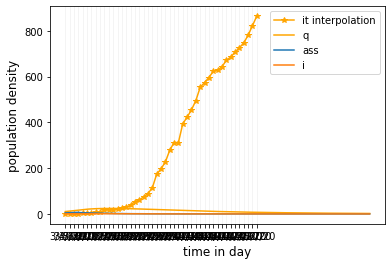

Epidemimiological pic = 10, I+Q=24, Death num D=5 



In [15]:
tmax=70#len(ddata.Cases)
dt=float(1./24) # par tranche de 6 h   
timeSet=np.arange(0,tmax,dt) 

corona.calSol(timeSet,y0)
corona.plotSAsQI(ddata,timeSet)

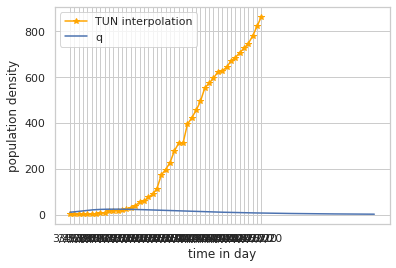

In [16]:

sn.set(style="whitegrid")
fig, ax = plt.subplots()
   
line1,= plt.plot(ddata.date,ddata.confirmed,c='orange',marker='*',label='TUN interpolation')
line2,=ax.plot(timeSet,corona.q,label='q')
 #line3,=ax.plot(timeSet,self.ass,label='ass')
   #  line3,=ax.plot(timeSet,self.i+self.ass,label='i+ass')     
plt.xlabel(r'time in day',fontsize=12)
plt.ylabel(r"population density",fontsize=12)
 #plt.title()
ax.legend(loc='upper left')
 #plt.savefig('../results/fig111.png', transparent=True)
plt.show()

In [17]:
corona.alpha1

3.780482574856971e-08

In [18]:
def residual(param,data):
    res=np.zeros(len(data.shape))
    ndp, nbatch = data.shape[0]
    time = data.xdata[0][:,0]
    y1data = data.ydata[0][:, 0] # cases
  #  y2data = data.ydata[1][:, 0] # death
  #  y3data = data.ydata[2][:, 0] # recovery
    xdata = data.xdata[0][:,0]#data.user_defined_object[0]
    #par=(param[0],param[1],param[2])
    corona.tau1=param[0]
    corona.tau2=param[1]
    

    corona.calSol(time,y0)

    bb=1#param[4]
    ## l'optimisation est sur la base des i+ass+q
    # aa=q[(np.floor(timeSet)==timeSet)*(timeSet<len(ddata.date))]+ass[(np.floor(timeSet)==timeSet)*(timeSet<len(ddata.date))]+i[(np.floor(timeSet)==timeSet)*(timeSet<len(ddata.date))]
      ## l'optimisation est sur la base des i+q
    aa=corona.q#+corona.i
    dd=corona.d
    rr=corona.r
    res[0]= np.linalg.norm(aa-y1data)
   # res[1]=np.linalg.norm(dd-y2data)
 #   res[2]=np.linalg.norm(rr-y3data)
    return res


# initialize MCMC object
mcstat = MCMC()
# initialize data structure 
#OPtFuncDim1
# ydata=np.column_stack((ddata.Cases,ddata.cumDeath))
# mcstat.data.add_data_set(x=ddata.date, y=ydata)#, user_defined_object=ddata.date)

tt=np.arange(len(ddata.date))
mcstat.data.add_data_set(x=tt, y=ddata.confirmed)#, user_defined_object=ddata.date)
#mcstat.data.add_data_set(x=ddata.date[:27], y=ddata.cumDeath[:27],weight=0)#, user_defined_object=ddata.date)
#mcstat.data.add_data_set(x=ddata.date[:27], y=ddata.cumRecover[:27],weight=0)#, user_defined_object=ddata.date)
# initialize parameter array

# add model parameters
mcstat.parameters.add_model_parameter(name='tau1', theta0=tau1.value, minimum=0,maximum=1, prior_mu=tau1, prior_sigma=0.1)
mcstat.parameters.add_model_parameter(name='tau2', theta0=tau2.value, minimum=0,maximum=1,prior_mu=tau2,prior_sigma=0.01)
#mcstat.parameters.add_model_parameter(name='efficacite_Conf', theta0=corona.efficacite_Conf, minimum=0.01,maximum=0.09)
 
                                 
# # initial values for the model states
# mcstat.parameters.add_model_parameter(name='S0', theta0=0.77, minimum=0,
#                                       maximum=np.inf, prior_mu=0.77,
#                                       prior_sigma=2)
# mcstat.parameters.add_model_parameter(name='I0', theta0=1.3, minimum=0,
#                                       maximum=np.inf, prior_mu=1.3,
#                                       prior_sigma=2)
# mcstat.parameters.add_model_parameter(name='R0', theta0=10, minimum=0,
#                                       maximum=np.inf, prior_mu=10,
#                                       prior_sigma=2)

# Generate options
mcstat.simulation_options.define_simulation_options(
    nsimu=1.5e+3, updatesigma=True)
# Define model object:
mcstat.model_settings.define_model_settings(
    sos_function=residual)#,
 #   sigma2=0.05**2)#,
   # S20=np.array([1,1]))
   # N0=np.array([4,4,4]))


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
      tau1:      0.35 [ 0.00e+00,      1.00] N(     0.35,     0.10^2)
      tau2:      0.78 [ 0.00e+00,      1.00] N(     0.78, 1.00e-02^2)
 [-----------------100%-----------------] 1500 of 1500 complete in 207.4 sec

------------------------------
name      :       mean        std     MC_err        tau     geweke
tau1      :     0.3635     0.0942     0.0082     5.5464     0.8953
tau2      :     0.7766     0.0106     0.0008     5.5447     0.9976
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 34.60%
Stage 2: 51.60%
Net    : 86.20% -> 1293/1500
---------------
Chain provided:
Net    : 86.13% -> 646/750
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


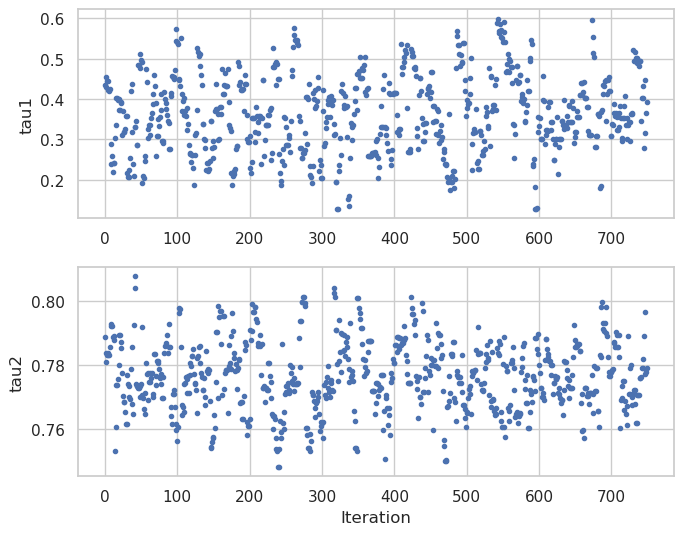

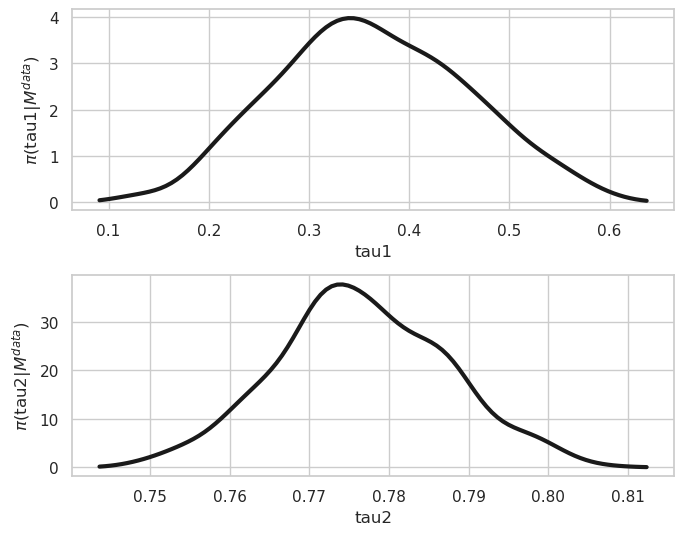

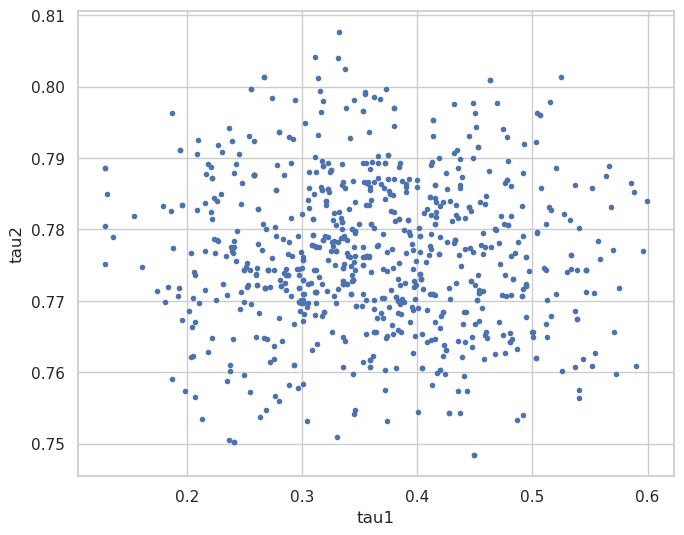

In [19]:
# Run simulation
mcstat.run_simulation()
# Rerun starting from results of previous run
#mcstat.simulation_options.nsimu = int(3e+4)
#mcstat.run_simulation(use_previous_results=True)

# extract info from results
results = mcstat.simulation_results.results
burnin = int(results['nsimu']/2)
chain = results['chain'][burnin:, :]
s2chain = results['s2chain'][burnin:, :]
names = results['names'] # parameter names

# display chain stats
mcstat.chainstats(chain, results)

from pymcmcstat import mcmcplot as mcp
settings = dict(
    fig=dict(figsize=(7, 6))
)
# plot chain panel
mcp.plot_chain_panel(chain, names, settings)
# plot density panel
mcp.plot_density_panel(chain, names, settings)
# pairwise correlation
f = mcp.plot_pairwise_correlation_panel(chain, names, settings)


Generating credible/prediction intervals:

 [-----------------100%-----------------] 500 of 500 complete in 46.1 sec
Interval generation complete



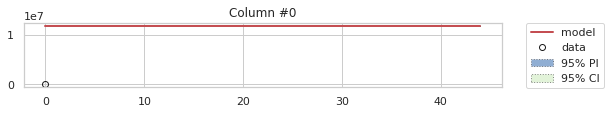

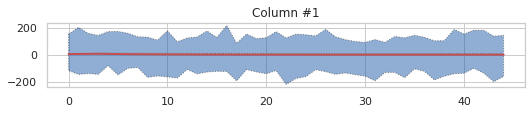

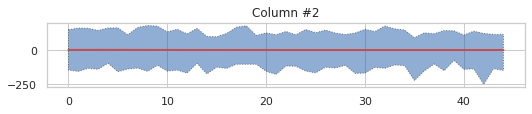

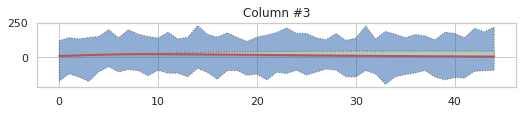

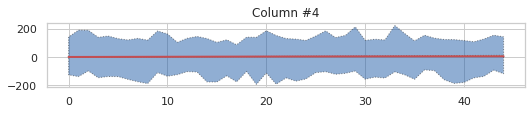

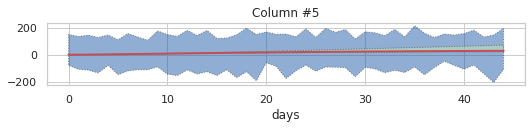

In [20]:

from pymcmcstat import propagation as up


def predmodelfun(data,param):
    obj = data.xdata
    time = obj[0][:,0]
    xdata = obj
    # last 3 parameters are the initial states
    #y0 = np.array(q[-3:])

    corona.tau1=param[0]
    corona.tau2=param[1]
    #corona.efficacite_Conf=param[0]

    # evaluate model
    #ymodel = np.zeros([time.size, 3])
    tmodel, ymodel = corona.calSol(time,y0)
    return ymodel


mcstat.PI.setup_prediction_interval_calculation(
    results=results,
    data=mcstat.data,
    modelfunction=predmodelfun)

mcstat.PI.generate_prediction_intervals(
    nsample=500,
    calc_pred_int=True,
    waitbar=True)


# plot prediction intervals
fighandle, axhandle = mcstat.PI.plot_prediction_intervals(
    adddata=False,
    addlegend=False,
    figsizeinches=[7.5, 8])
for ii in range(1):
    axhandle[ii].plot(mcstat.data.ydata[0][:, 0],
                    #  mcstat.data.ydata[0][:, ii + 1],
                      'ko', mfc='none', label='data')
    axhandle[ii].set_ylabel('')
    #axhandle[ii].set_title(ylbls[ii + 1][0])
    axhandle[ii].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axhandle[-1].set_xlabel('days');




In [21]:
#################################
#Ne pas toucher
#paramFig1=[[0.279-0.013,0.95],[0.279,1],[0.279+0.013,1.05]]
#################################################################       

tmax=100
timeSet=np.arange(t0,tmax,dt)

param=[[0.77,0.75,0.78],[0.187,0.191,0.195]]
#print('(beta, efficacite_Conf,tau2)= (%.4f,%.4f,%.4f)' % (results['mean'][0],results['mean'][1],results['mean'][2]))
#print('(alpha, beta)= (%.4f,%.4f)' % (results['mean'][0],results['mean'][1]))

ress=[]

for i in np.arange(np.shape(param)[1]):
    corona.tau1=param[0][i]#0.0 # taux de mise en quarantaine pour les infectes
    corona.tau2=param[1][i]
    
    y0=corona.calc_params(ddata.population,chi1,chi2,chi3)
    
    time,res= corona.calSol(timeSet,y0)
    
    ress.append(np.array([param[0][i],param[1][i],corona.q]))
    

fig, ax = plt.subplots()
ax.grid(True)
line1,= plt.plot(ddata.date[:tmax],ddata.confirmed[:tmax],c='orange',marker='*',label='TUN interpolation')

ax.fill_between(timeSet,ress[2][2],ress[0][2],alpha=0.2)
ax.plot(timeSet,ress[0][2],label='q(t)')
ax.plot(timeSet,ress[1][2],label='q(t)')
ax.plot(timeSet,ress[2][2],label='q(t)')
#plt.axvline(timeSet[(timeSet<19+dt) * (timeSet>19)], color='black', linestyle='-.', alpha=.5)
#plt.axvline(timeSet[(timeSet<24+dt) * (timeSet>24)], color='black', linestyle='-.', alpha=.5)

ax.text( 1, 6,
        '6PM-6AM curfew ',
          rotation=90,
          horizontalalignment='center',
          verticalalignment='top',
          multialignment='center',
          size=10)


# plt.text(23, 1500, 'containment',
#          rotation=90,
#          horizontalalignment='center',
#          verticalalignment='top',
#          multialignment='center',
#           size=10)

#line3,=ax.plot(timeSet,self.ass,label='ass')
  #  line3,=ax.plot(timeSet,self.i+self.ass,label='i+ass')     
plt.xlabel(r'time in day',fontsize=12)
plt.ylabel(r"population density",fontsize=12)
#plt.title()
ax.legend(loc='upper left')
#plt.savefig('../results/fig111.png', transparent=True)
plt.show()




NameError: name 't0' is not defined

## Optimisation du reste de la courbe

### Mise à jour des parametre convid

In [ ]:
tau1.value=0.75
tau2.value=0.191
start_conf.value=26.5#28.7
efficacite_Conf.set=.3

corona=cv.SAsIQR(beta=covidParams['beta'].value,tau1=covidParams['tau1'].value,tau2=covidParams['tau2'].value,gama=covidParams['gama'].value,
            mu=covidParams['mu'].value,alpha1=covidParams['alpha1'].value,f=covidParams['f'].value,start_conf=covidParams['start_conf'].value,
             efficacite_Conf=covidParams['efficacite_Conf'].value ,confinement_hour=covidParams['confinement_hour'].value)



y0=corona.calc_params(ddata.population,chi1,chi2,chi3)


#### Optimisation avec confinement et couvre feux

Periode 1

In [ ]:
timeSet1=np.arange(t0,start_conf.value,dt)  


#plt.plot(aa, np.vectorize(corona.f2)(1,1,1,aa))    
time1 , res1=corona.calSol(timeSet1,y0)
corona.plotSAsQI(ddata,timeSet1)


dd=int(np.max(corona.d))*np.ones(4)

Periode 2

In [ ]:
tmaxPerd2=100
timeSet2=np.arange(np.max(timeSet1),tmaxPerd2,dt)



#start_conf=np.infty
#              efficacite_Conf=efficacite_Conf) 


   
ass0=corona.ass[-1]#/ddata.popNumber#1/100
i0= corona.i[-1]
q0=corona.q[-1]
d0=corona.d[-1]
r0=corona.r[-1]
s0=ddata.population-(ass0+i0+q0+d0+r0)#1.-(ass0+i0+q0+d0+r0) #if s<0.2 else 0

#################
#param=(beta,tau1,tau2) 
y0=[s0,ass0,i0,q0,d0,r0]


covidParams['efficacite_Conf'].value=0.02


corona2=cv.SAsIQR(beta=covidParams['beta'].value,tau1=covidParams['tau1'].value,tau2=covidParams['tau2'].value,gama=covidParams['gama'].value,
            mu=covidParams['mu'].value,alpha1=covidParams['alpha1'].value,f=covidParams['f'].value,start_conf=covidParams['start_conf'].value,
             efficacite_Conf=covidParams['efficacite_Conf'].value ,confinement_hour=covidParams['confinement_hour'].value)



corona2.calc_params(ddata.population,chi1,chi2,chi3)

plt.plot(timeSet2[:54], np.vectorize(corona2.f2)(1,1,1,timeSet2[:54]))   

time3_1 , res3_1=corona2.calSol(timeSet2,y0)

corona2.plotSAsQI(ddata,time3_1)
dd[0]+=int(max(corona2.d))



In [ ]:
covidParams['efficacite_Conf'].value

Plot de la solution (2 periode)

In [ ]:
resSR = pd.concat([pd.DataFrame(res1),pd.DataFrame(res3_1)])

time=np.concatenate((time1,time3_1))
############################################
#   Anglaise
#

import seaborn as sns
fig, ax = plt.subplots()
line5,= plt.plot(np.arange(len(ddata.date)),ddata.confirmed,label='TUN data',marker='*',c='orange')
line1,=ax.plot(time,resSR[3],c='r',label='12h of curfews and containment.\n Death num.='+str(int(dd[0])))


plt.axvline(time[(time<19+dt) * (time>19)], color='black', linestyle='-.', alpha=.5)
plt.axvline(time[(time<24+dt) * (time>24)], color='black', linestyle='-.', alpha=.5)
plt.axvline(time[(time<28+dt) * (time>28)], color='black', linestyle='-.', alpha=.5)

plt.text(16, 650, '6PM-6AM curfew ',
         rotation=90,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center',
          size=10)


plt.text(28, 250, 'containment',
         rotation=90,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center',
          size=10)


#line2,=ax.plot(bb[len(res1):],res2[:,2],label='periode 2')
#plt.plot(bb, aa[:,1])
plt.xlabel('Days since first case',fontsize=10)
plt.ylabel(r"Q(t)",fontsize=10)
#plt.title('Couvre-feu de 18h vs pression de confinement' )
ax.legend(loc='lower right',fontsize=9)
        #plt.savefig('../results/fig112.png', transparent=True)
plt.show()


